In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import joblib

In [19]:
# Load the dataset
df = pd.read_csv('processed_coconut_data.csv')
df.head(2)

,Date,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Coconut Count
0,1930-05-31,20.23136,31.033891,41.227105,5,27.823293,64.297799,5.281903,1,307.90744
1,1930-06-30,20.23136,31.033891,41.227105,4,27.823293,64.297799,5.281903,1,307.90744


In [20]:
X = df.drop(['Date','Rain Status (0/1)','Coconut Count'], axis=1) 
y = df['Coconut Count']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Initialize models
models = {
   'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
   'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
   'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
   'ANN': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
   'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [23]:
from sklearn.metrics import mean_squared_error

def calculate_accuracy(y_true, y_pred):
   mse = mean_squared_error(y_true, y_pred)
   rmse = np.sqrt(mse)
   accuracy = 100 * (1 - rmse / np.mean(y_true))
   return max(0, accuracy)

In [24]:
results = {}
best_score = float('-inf')
best_model = None

for name, model in models.items():
   model.fit(X_train, y_train)
   y_pred = model.predict(X_test)
   
   accuracy = calculate_accuracy(y_test, y_pred)
   r2 = r2_score(y_test, y_pred) * 100  # Convert to percentage
   cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
   cv_percentage = cv_scores.mean() * 100
   
   results[name] = {
       'Accuracy': accuracy,
       'R2_Percentage': r2,
       'CV_Accuracy': cv_percentage,
       'CV_std': cv_scores.std() * 100
   }
   
   if cv_scores.mean() > best_score:
       best_score = cv_scores.mean()
       best_model = model

In [25]:
# Print results
print("Model Comparison Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {metrics['Accuracy']:.2f}%")
    print(f"R2 Score: {metrics['R2_Percentage']:.2f}%")
    print(f"Cross-val R2: {metrics['CV_Accuracy']:.2f}% (+/- {metrics['CV_std']*2:.2f}%)")

print("\nBest Model Selected:", 
      [name for name, model in models.items() if model == best_model][0])

Model Comparison Results:

Random Forest:
Accuracy: 89.55%
R2 Score: -0.53%
Cross-val R2: -7.19% (+/- 12.65%)

XGBoost:
Accuracy: 89.27%
R2 Score: -6.05%
Cross-val R2: -32.20% (+/- 15.58%)

SVR:
Accuracy: 89.62%
R2 Score: 0.79%
Cross-val R2: 0.05% (+/- 0.50%)

ANN:
Accuracy: 89.07%
R2 Score: -10.10%
Cross-val R2: -18.02% (+/- 23.08%)

Gradient Boosting:
Accuracy: 89.49%
R2 Score: -1.84%
Cross-val R2: -10.63% (+/- 14.43%)

Best Model Selected: SVR


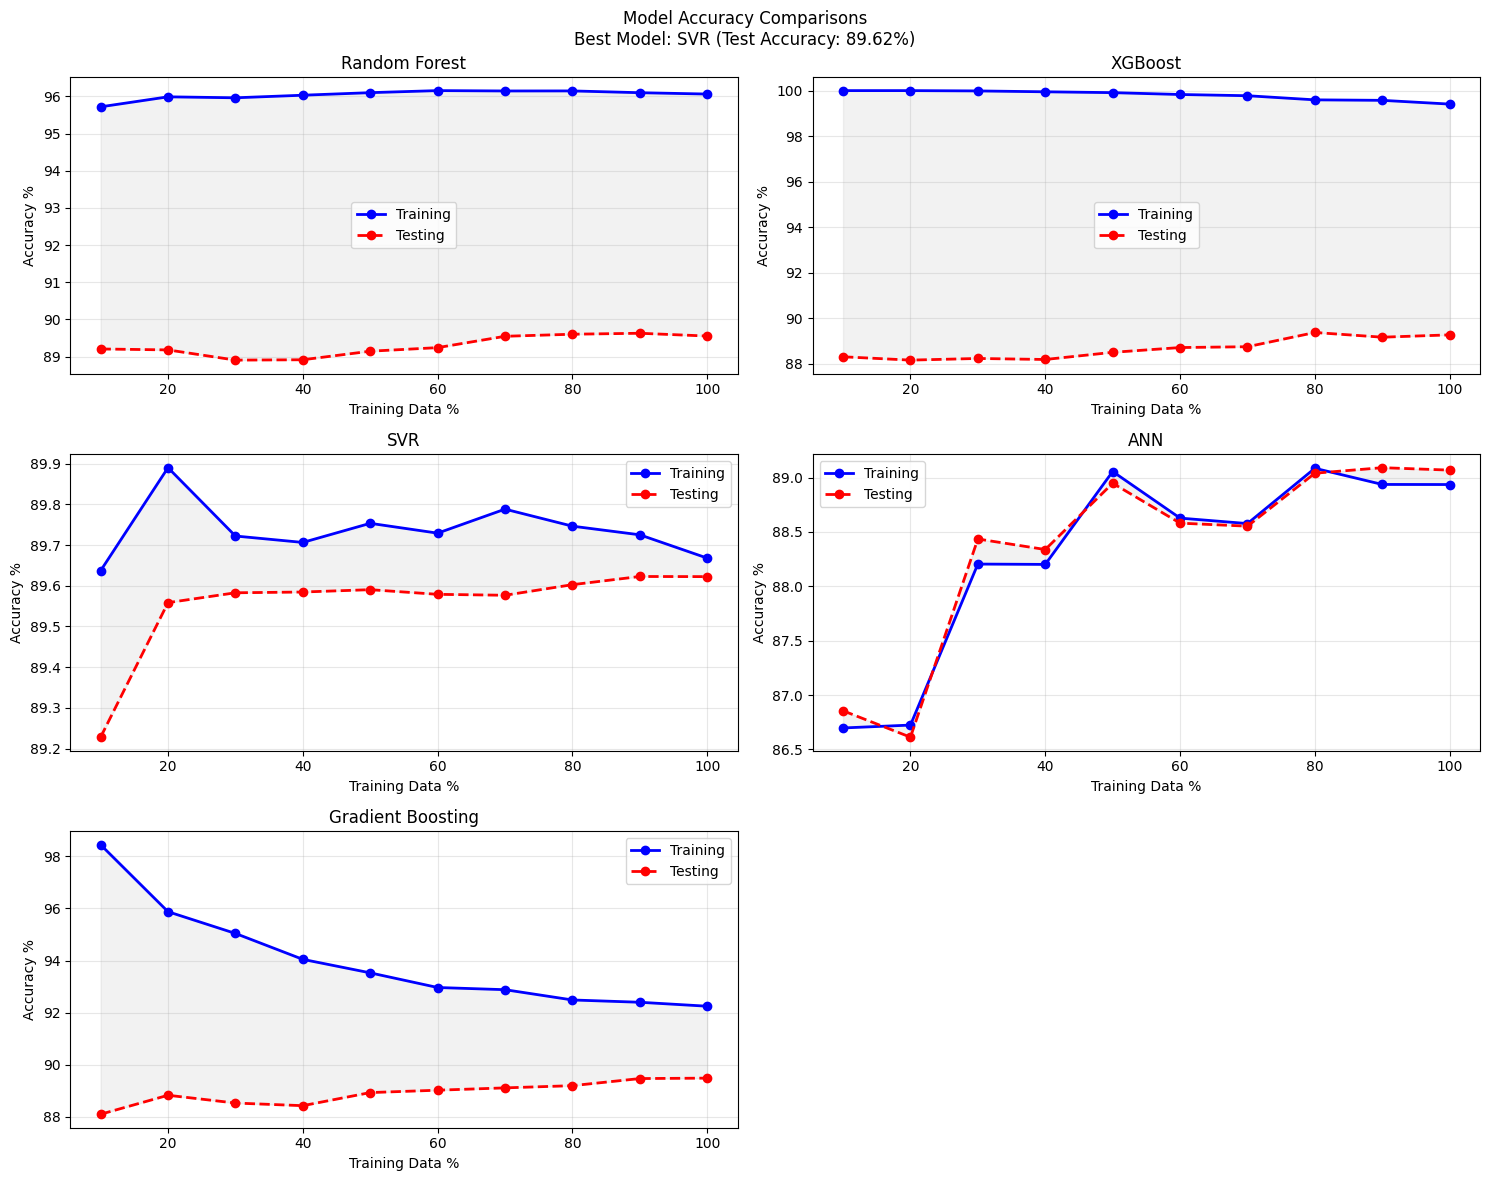


Final Accuracies for Each Model:
--------------------------------------------------

Random Forest:
Training Accuracy: 96.07%
Testing Accuracy: 89.55%

XGBoost:
Training Accuracy: 99.41%
Testing Accuracy: 89.27%

SVR:
Training Accuracy: 89.67%
Testing Accuracy: 89.62%

ANN:
Training Accuracy: 88.94%
Testing Accuracy: 89.07%

Gradient Boosting:
Training Accuracy: 92.25%
Testing Accuracy: 89.49%

Best Model: SVR (Test Accuracy: 89.62%)


In [26]:
import matplotlib.pyplot as plt

def plot_models_accuracy(models, X_train, X_test, y_train, y_test):
    time_points = np.linspace(0.1, 1.0, 10)
    n_samples = len(X_train)
    colors = {'Train': 'blue', 'Test': 'red'}
    best_test_acc = -np.inf
    best_model_name = None
    
    # Dictionary to store final accuracies
    final_accuracies = {}
    
    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models.items()):
        train_accuracies = []
        test_accuracies = []
        
        for fraction in time_points:
            n_subset = int(n_samples * fraction)
            X_subset = X_train[:n_subset]
            y_subset = y_train[:n_subset]
            
            model.fit(X_subset, y_subset)
            train_pred = model.predict(X_subset)
            test_pred = model.predict(X_test)
            
            train_acc = calculate_accuracy(y_subset, train_pred)
            test_acc = calculate_accuracy(y_test, test_pred)
            
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            
            # Store final accuracies (when fraction = 1.0)
            if fraction == 1.0:
                final_accuracies[name] = {
                    'train': train_acc,
                    'test': test_acc
                }
                
                # Track best model
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_model_name = name
        
        axes[idx].plot(time_points * 100, train_accuracies, '-o', 
                      color=colors['Train'], label='Training', linewidth=2)
        axes[idx].plot(time_points * 100, test_accuracies, '--o', 
                      color=colors['Test'], label='Testing', linewidth=2)
        
        axes[idx].fill_between(time_points * 100, train_accuracies, 
                             test_accuracies, alpha=0.1, color='gray')
        
        axes[idx].set_xlabel('Training Data %')
        axes[idx].set_ylabel('Accuracy %')
        axes[idx].set_title(f'{name}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
    # Remove empty subplot
    axes[-1].remove()
    
    plt.suptitle(f'Model Accuracy Comparisons\nBest Model: {best_model_name} (Test Accuracy: {best_test_acc:.2f}%)', 
                 size=12)
    plt.tight_layout()
    plt.show()
    
    # Print final accuracies for each model
    print("\nFinal Accuracies for Each Model:")
    print("-" * 50)
    for name, accuracies in final_accuracies.items():
        print(f"\n{name}:")
        print(f"Training Accuracy: {accuracies['train']:.2f}%")
        print(f"Testing Accuracy: {accuracies['test']:.2f}%")
    
    print(f"\nBest Model: {best_model_name} (Test Accuracy: {best_test_acc:.2f}%)")

# Call function
plot_models_accuracy(models, X_train, X_test, y_train, y_test)


Metrics for Random Forest:
--------------------------------------------------
R² Score: -0.005
RMSE: 31.258
MAE: 27.158

Metrics for XGBoost:
--------------------------------------------------
R² Score: -0.060
RMSE: 32.104
MAE: 26.921

Metrics for SVR:
--------------------------------------------------
R² Score: 0.008
RMSE: 31.053
MAE: 27.638

Metrics for ANN:
--------------------------------------------------
R² Score: -0.101
RMSE: 32.712
MAE: 28.382

Metrics for Gradient Boosting:
--------------------------------------------------
R² Score: -0.018
RMSE: 31.460
MAE: 27.235


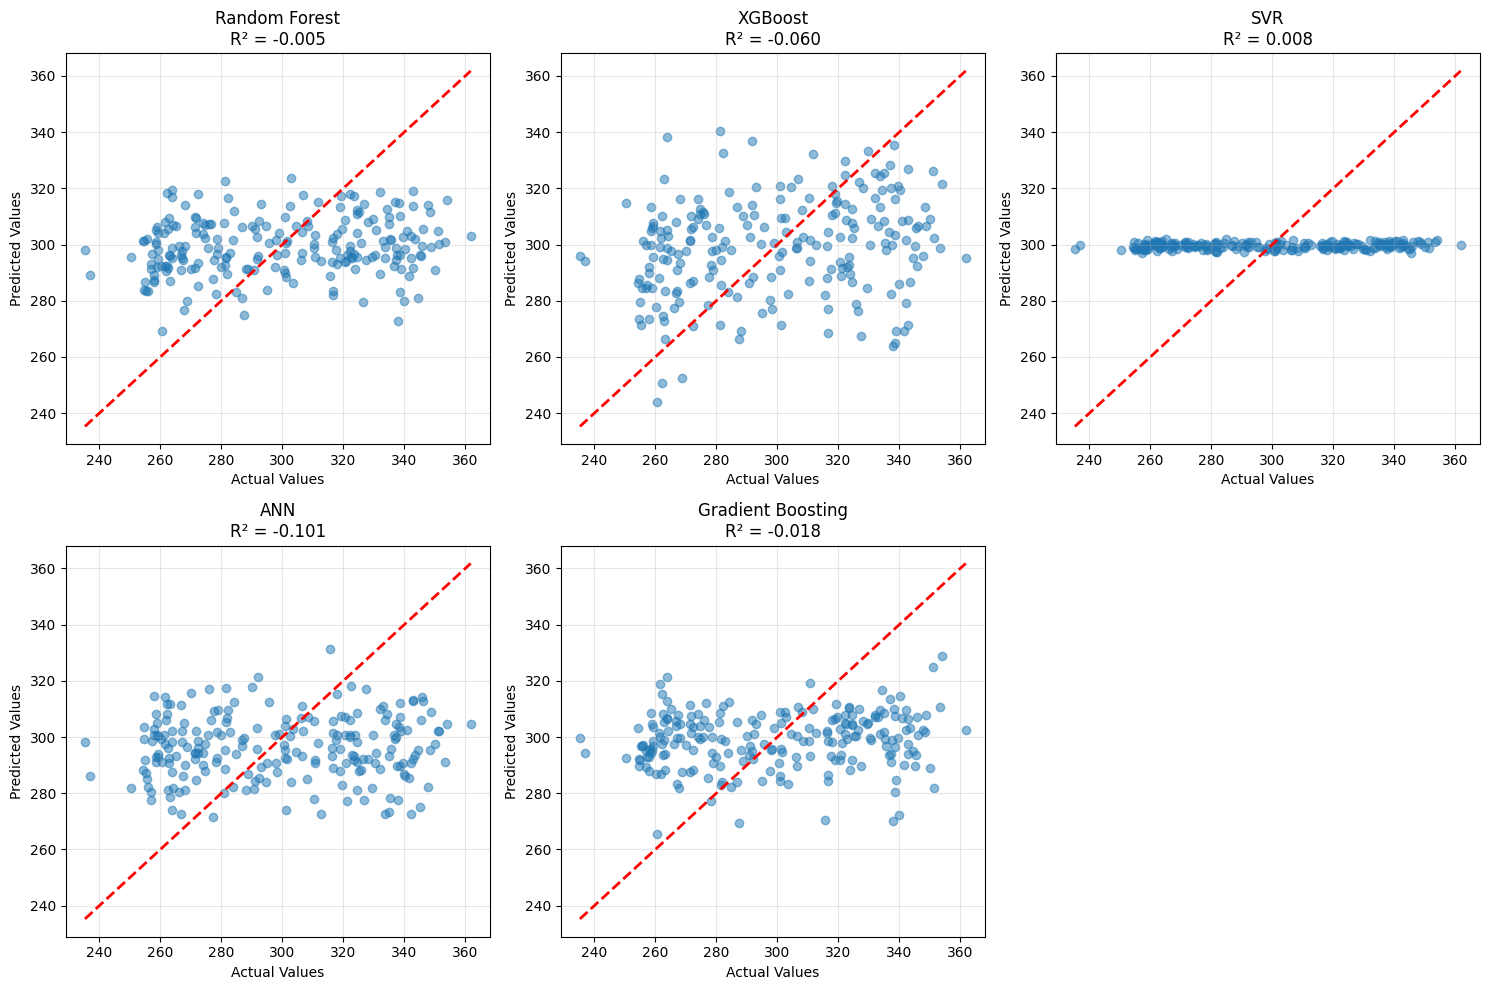

In [27]:
def plot_regression_analysis(models, X_train, X_test, y_train, y_test):
    # Calculate number of rows needed (we'll put 3 plots per row)
    n_models = len(models)
    n_rows = (n_models + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models.items()):
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Create scatter plot
        axes[idx].scatter(y_test, y_pred, alpha=0.5)
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                      'r--', lw=2)  # Perfect prediction line
        axes[idx].set_title(f'{name}\nR² = {r2:.3f}')
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].grid(True, alpha=0.3)
        
        # Print metrics
        print(f"\nMetrics for {name}:")
        print("-" * 50)
        print(f"R² Score: {r2:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAE: {mae:.3f}")
        
    # Remove empty subplots if any
    for idx in range(len(models), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Make sure to import necessary metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Plot regression analysis
plot_regression_analysis(models, X_train, X_test, y_train, y_test)

In [28]:
# Save the model to a file
joblib.dump(best_model, 'best_yield_predictor_for_long_trem_patterns.pkl')

['best_yield_predictor_for_long_trem_patterns.pkl']

In [29]:
import requests
import pandas as pd
import joblib
from datetime import datetime

def get_weather_data(city="Kuliyapitiya", api_key="5dd16e6569f3cdae6509d32002b9dc67"):
   """
   Get weather data from OpenWeatherMap API
   """
   base_url = "http://api.openweathermap.org/data/2.5/weather"
   
   params = {
       'q': city,
       'appid': api_key,
       'units': 'metric'
   }
   
   try:
       response = requests.get(base_url, params=params)
       data = response.json()
       
       if response.status_code == 200:
           weather_data = {
               'Temperature (°C)': data['main']['temp'],
               'Humidity (%)': data['main']['humidity'],
               'Rainfall (mm)': data['rain']['1h'] if 'rain' in data else 0
           }
           return weather_data, True
       else:
           print(f"Error: {data['message']}")
           return None, False
           
   except Exception as e:
       print(f"Error fetching weather data: {str(e)}")
       return None, False

def predict_yield_with_weather(soil_moisture_data, api_key):
   # Get weather data
   weather_data, success = get_weather_data(api_key=api_key)
   
   if not success:
       return None
   
   # Combine soil moisture and weather data
   input_data = pd.DataFrame({
       'Soil Moisture (10 cm) (%)': [soil_moisture_data['sm_10']],
       'Soil Moisture (20 cm) (%)': [soil_moisture_data['sm_20']],
       'Soil Moisture (30 cm) (%)': [soil_moisture_data['sm_30']],
       'Plant Age (years)': [soil_moisture_data['age']],
       'Temperature (°C)': [weather_data['Temperature (°C)']],
       'Humidity (%)': [weather_data['Humidity (%)']],
       'Rainfall (mm)': [weather_data['Rainfall (mm)']]
   })
   
   # Print all input parameters
   print("\nInput Parameters:")
   print("-----------------")
   print(f"Soil Moisture at 10cm: {soil_moisture_data['sm_10']}%")
   print(f"Soil Moisture at 20cm: {soil_moisture_data['sm_20']}%")
   print(f"Soil Moisture at 30cm: {soil_moisture_data['sm_30']}%")
   print(f"Plant Age: {soil_moisture_data['age']} years")
   print(f"Temperature: {weather_data['Temperature (°C)']}°C")
   print(f"Humidity: {weather_data['Humidity (%)']}%")
   print(f"Rainfall: {weather_data['Rainfall (mm)']}mm")
   
   try:
       model = joblib.load('best_yield_predictor.pkl')
       prediction = model.predict(input_data)
       return prediction[0]
   except Exception as e:
       print(f"Error making prediction: {str(e)}")
       return None

# Example usage
if __name__ == "__main__":
   API_KEY = "5dd16e6569f3cdae6509d32002b9dc67"
   
   # Example soil moisture data
   soil_data = {
       'sm_10': 19.89,
       'sm_20': 41.67,
       'sm_30': 34.82,
       'age': 3
   }
   
   # Get prediction
   prediction = predict_yield_with_weather(soil_data, API_KEY)
   
   if prediction is not None:
       print(f"\nPredicted Coconut Yield: {prediction:.2f}")
       
       # Get additional weather information
       weather_data, success = get_weather_data(api_key=API_KEY)
       if success:
           print("\nAdditional Weather Information:")
           print("------------------------------")
           for key, value in weather_data.items():
               print(f"{key}: {value}")
           
       print("\nPrediction Time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


Input Parameters:
-----------------
Soil Moisture at 10cm: 19.89%
Soil Moisture at 20cm: 41.67%
Soil Moisture at 30cm: 34.82%
Plant Age: 3 years
Temperature: 24.87°C
Humidity: 93%
Rainfall: 0mm

Predicted Coconut Yield: 297.91

Additional Weather Information:
------------------------------
Temperature (°C): 24.87
Humidity (%): 93
Rainfall (mm): 0

Prediction Time: 2024-11-30 16:50:43
